In [60]:
#pip install pandas
#pip install numpy
#pip install opencv-python-headless
#pip install matplotlib
#pip install scikit-learn
#pip install tensorflow

In [61]:
#importing requirements 
import os 
import pandas as pd
import numpy as np
import cv2 
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D,Flatten,Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [62]:
#data extractor 
def importData(main_folder):

    csv_paths = []

    for i in os.listdir(main_folder):
        sub_path =  main_folder +'/'+ i 
        for csv_file in os.listdir(sub_path):
            if(csv_file.endswith(".csv")):
                csv_path = sub_path + "/" + csv_file
                if(os.path.exists(csv_path)):
                    csv_paths.append(csv_path)
    
    data_frames = []

    for file_index in range(len(csv_paths)):
        csv_file_path = csv_paths[file_index]

        dataframe = pd.read_csv(csv_file_path)
        imageFilePath = os.path.dirname(csv_file_path)

        dataframe['imageName'] = imageFilePath + "/" + dataframe['imageName'] + ".jpg"
        data_frames.append(dataframe)

    data = pd.concat(data_frames, ignore_index=True)
    return data 

In [65]:
def balanceData(data,display=True):
    nBin = 31
    samplesPerBin =  500
    zeroAngleBinSample = samplesPerBin
    hist, bins = np.histogram(data['steeringAngle'], nBin)
    if display:
        center = (bins[:-1] + bins[1:]) * 0.5
        plt.bar(center, hist, width=0.03)
        plt.plot((np.min(data['steeringAngle']), np.max(data['steeringAngle'])), (samplesPerBin, samplesPerBin))
        plt.title('Data Visualisation')
        plt.xlabel('Steering Angle')
        plt.ylabel('No of Samples')
        plt.show()
    removeindexList = []
    for j in range(nBin):
        binDataList = []
        for i in range(len(data['steeringAngle'])):
            if data['steeringAngle'][i] >= bins[j] and data['steeringAngle'][i] <= bins[j + 1]:
                binDataList.append(i)
        binDataList = shuffle(binDataList)
        if j!=15:
            binDataList = binDataList[samplesPerBin:]
        else:
            binDataList = binDataList[zeroAngleBinSample:]
        removeindexList.extend(binDataList)

    print('Removed Images:', len(removeindexList))
    data.drop(data.index[removeindexList], inplace=True)
    print('Remaining Images:', len(data))
    if display:
        hist, _ = np.histogram(data['steeringAngle'], (nBin))
        plt.bar(center, hist, width=0.03)
        plt.plot((np.min(data['steeringAngle']), np.max(data['steeringAngle'])), (samplesPerBin, samplesPerBin))
        plt.title('Balanced Data')
        plt.xlabel('Steering Angle')
        plt.ylabel('No of Samples')
        plt.show()
    return data

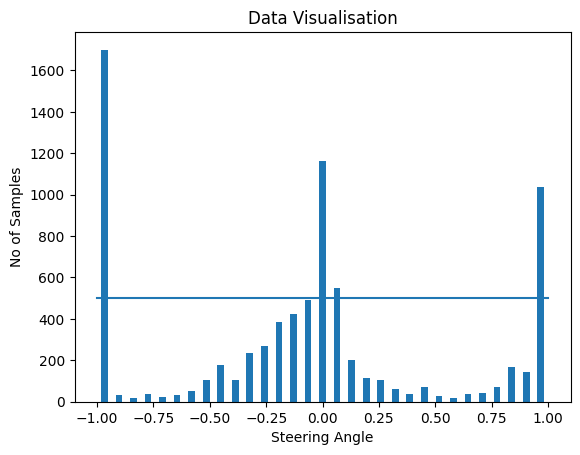

Removed Images: 2446
Remaining Images: 5479


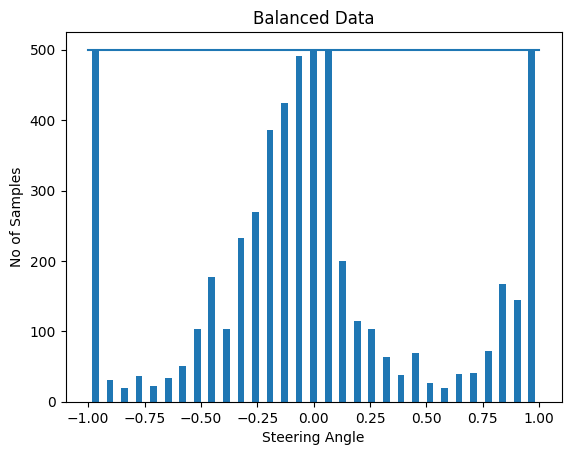

In [66]:
df = importData("D:/3_Education/My Comp/Business_Analytics/Business_analytics_python/07_Raspberry Pi/YouTube Video/05_CNN_Training/01_Input_Data")
data = balanceData(df)

In [67]:
#data preprocessing 
x_data = []
y_data = []

def image_preprocessor(image):
    img = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img

def get_xyTrain(dataframe):
    for index, row in dataframe.iterrows():
        filepath = row[dataframe.columns[0]]
        angle = row[dataframe.columns[1]]

        img = cv2.imread(filepath)
        processed_img = image_preprocessor(img)
        x_data.append(processed_img)
        y_data.append(angle)
    
    return np.asarray(x_data), np.asarray(y_data)

In [68]:
#test-train split 
x_data_np, y_data_np = get_xyTrain(data)
X_train, X_test, y_train, y_test = train_test_split(x_data_np, y_data_np, test_size=0.05, random_state=42)

MemoryError: Unable to allocate 1.62 GiB for an array with shape (5479, 66, 200, 3) and data type float64

In [69]:
#training without ImageGen 

#### STEP-7 : CREATE MODEL
def createModel():
    model = Sequential()

    model.add(Convolution2D(24, (5, 5), (2, 2), input_shape=(66, 200, 3), activation='elu'))
    model.add(Convolution2D(36, (5, 5), (2, 2), activation='elu'))
    model.add(Convolution2D(48, (5, 5), (2, 2), activation='elu'))
    model.add(Convolution2D(64, (3, 3), activation='elu'))
    model.add(Convolution2D(64, (3, 3), activation='elu'))

    model.add(Flatten())
    model.add(Dense(100, activation = 'elu'))
    model.add(Dense(50, activation = 'elu'))
    model.add(Dense(10, activation = 'elu'))
    model.add(Dense(1))
    
    

    model.compile(optimizer=Adam(learning_rate=0.00001), loss='mse')
    return model


In [70]:
epoch_1=3
model = createModel()
history = model.fit(X_train,y_train,validation_split=0.3,epochs=epoch_1,batch_size=64,verbose=1)

Epoch 1/3
45/45 [==============================] - 24s 445ms/step - loss: 0.2851 - val_loss: 0.2941
Epoch 2/3
45/45 [==============================] - 17s 368ms/step - loss: 0.2542 - val_loss: 0.2763
Epoch 3/3
45/45 [==============================] - 17s 369ms/step - loss: 0.2386 - val_loss: 0.2604


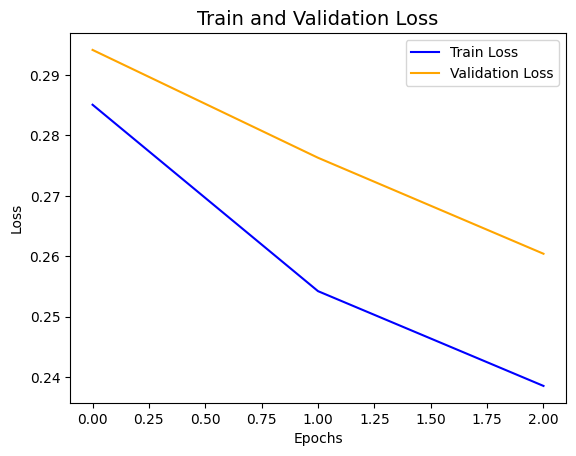

In [71]:

epochs = [i for i in range(epoch_1)]
loss_train = history.history['loss']
loss_test = history.history['val_loss']


plt.plot(epochs, loss_train, color='blue', label='Train Loss')
plt.plot(epochs, loss_test, color='orange', label='Validation Loss')
plt.title('Train and Validation Loss', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [72]:
import datetime
# Define the save directory
save_dir = "D:/3_Education/My Comp/Business_Analytics/Business_analytics_python/07_Raspberry Pi/YouTube Video/05_CNN_Training/03_Model_file"

# Get the current time
current_time = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")

# Create the full model filename
model_filename = os.path.join(save_dir, f"model_{current_time}.h5")
model.save(model_filename)

D:\5_Python\envs\cnn_env\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [73]:
#Convert to tflite 
#representative dataset for Int8 Quantization
X_train = np.array(X_train, dtype=np.float32)
def representative_data_gen():
      for input_value in tf.data.Dataset.from_tensor_slices(X_train).batch(1).take(100):
        # Model has only one input so each data point has one element.
        yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

tflite_model_quant = converter.convert()

tf_model_filename = os.path.join(save_dir, f"model_{current_time}.tflite")
#save the model
with open(tf_model_filename, 'wb') as f:
      f.write(tflite_model_quant)

INFO:tensorflow:Assets written to: C:\Users\kumar\AppData\Local\Temp\tmp3si2sygr\assets


INFO:tensorflow:Assets written to: C:\Users\kumar\AppData\Local\Temp\tmp3si2sygr\assets
D:\5_Python\envs\cnn_env\Lib\site-packages\tensorflow\lite\python\convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [74]:
#inference engine by tflite runtime
#import tflite_runtime.interpreter as tflite_interp

def Inference_Engine(model_path, image):

    interpreter = tf.lite.Interpreter(model_path=model_path)
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    input_shape = input_details[0]['shape']

    #print("[+]expected input shape:", input_shape)
    input_type = input_details[0]['dtype']
    
    try:
        
        #print("[+]allocating tensor")
        interpreter.allocate_tensors()

        #internal processing
        input_tensor = np.array(image).astype(input_type)
        input_tensor = np.expand_dims(input_tensor, axis=0)

        #inference 
        #print("[+]performing inference")
        interpreter.set_tensor(input_details[0]['index'], input_tensor)
        interpreter.invoke()

        output = interpreter.get_tensor(output_details[0]['index'])
        #print("[+]inference completed")
        return output
    
    except Exception as e:
        print("[-]caught exception: ", e)
        return None

In [75]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Actual_str_angle 23
Predicted_str_angle 4
error 19


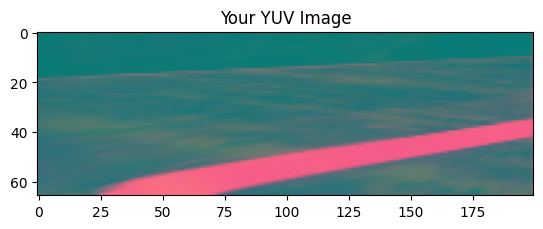

In [76]:
row_num = 5
output = Inference_Engine(tf_model_filename, X_test[row_num])
print('Actual_str_angle',int(y_test[row_num]*25))
print('Predicted_str_angle',int(output*25))
error = int(y_test[row_num]*25)-int(output*25)
print('error', error)
img = X_test[row_num]
fig, ax = plt.subplots()
ax.imshow(img, cmap=None)
ax.set_title('Your YUV Image')
plt.show()
